## Two-Device AlexNet architechture using PyTorch

This notebook contains:
1. A two-device version of AlexNet with upper- and lower-layers as described in the paper
2. A successful trial run on a small subset of the training data (32,768 images, 25 classes)
3. Two updated versions of 2048x image augmentation scheme from `augment_ingest.ipynb`:
    - The first method stores augmentation information as a sequence of `uint16` digits in an array
    - The second method uses the `hashlib` library to generate unique random numbers for each image and sample augmented versions of a diverse set of images sequentially (some additional minimal compute but ~zero memory overhead)

In [1]:
import os
import csv
import torch
import random
import hashlib
import itertools
import numpy as np
import polars as pl
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as nnF
from datetime import date, datetime
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
from plotting_preferences import plotting_preferences_AS

In [2]:
random.seed(234213)
np.random.seed(234213)
plotting_preferences_AS()

### 1. Creating a 2-GPU AlexNet model using Torch

The original paper used model parallelism using two GPUs. Since I am using a mac, the GPU is integrated and there is no way to specify the different cores of the GPU (turns out, _cores_ in a mac are a different from cores in a Nvidia or AMD GPU). So, I will split the model between the GPU and the CPU.

For the full training run, I will use the University's high-performance computer, where the model will be split across two GPUs.

In [3]:
# The model below has some unncessary ".to" statements but
# I am keeping them because they will be useful for the full
# model training on the HPC and adding them back will be tiresome
device1 = torch.device("mps")
device2 = torch.device("cpu")
device3 = device2 

In the model below, the input image is fed to both the top and bottom layers. However, **for the top layer, the bottom half is masked (pixel values are multiplied by `mask_value=0`) and vice-versa.** Masking was done because in the paper, the authors' stated that "One GPU runs the layer-parts at the *top of the figure* while the other runs the layer-parts at the bottom." I initially tried splitting the image into two halves, but this caused dimension mismatch issues. The masking approach was the best solution I could devise to replicate what the author's did in [the original publication.](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [4]:
class AlexNet(nn.Module):
    def __init__(self, number_of_classes=1000, mask_value=0, with_batches=True):
        super().__init__()

        self.number_of_classes = number_of_classes
        self.mask_value = mask_value
        self.with_batches = with_batches

        # The number of initialized layers below could be halved, but
        # But I am trying to explicitly define each of them here
        # In the final implementation, I will remove the redundancies
        
        self.conv1_top = nn.Conv2d(
            in_channels=3,
            out_channels=48,
            kernel_size=11,
            stride=4,
            padding=2,
        ).to(device1)

        self.conv1_bottom = nn.Conv2d(
            in_channels=3,
            out_channels=48,
            kernel_size=11,
            stride=4,
            padding=2,
        ).to(device2)

        self.conv2_top = nn.Conv2d(
            in_channels=48,
            out_channels=128,
            kernel_size=5,
            padding=2,
        ).to(device1)

        self.conv2_bottom = nn.Conv2d(
            in_channels=48,
            out_channels=128,
            kernel_size=5,
            padding=2,
        ).to(device2)

        self.conv3_top = nn.Conv2d(
            in_channels=256,
            out_channels=192,
            kernel_size=3,
            padding=1,
        ).to(device1)

        self.conv3_bottom = nn.Conv2d(
            in_channels=256,
            out_channels=192,
            kernel_size=3,
            padding=1,
        ).to(device2)

        self.conv4_top = nn.Conv2d(
            in_channels=192,
            out_channels=192,
            kernel_size=3,
            padding=1,
        ).to(device1)

        self.conv4_bottom = nn.Conv2d(
            in_channels=192,
            out_channels=192,
            kernel_size=3,
            padding=1,
        ).to(device2)

        self.conv5_top = nn.Conv2d(
            in_channels=192,
            out_channels=128,
            kernel_size=3,
            padding=1,
        ).to(device1)

        self.conv5_bottom = nn.Conv2d(
            in_channels=192,
            out_channels=128,
            kernel_size=3,
            padding=1,
        ).to(device2)

        self.dense6_top = nn.Linear(
            in_features=256 * 6 * 6, 
            out_features=2048,
        ).to(device1)

        self.dense6_bottom = nn.Linear(
            in_features=256 * 6 * 6,
            out_features=2048,
        ).to(device2)

        self.dense7_top = nn.Linear(
            in_features=4096, 
            out_features=2048,
        ).to(device1)

        self.dense7_bottom = nn.Linear(
            in_features=4096, 
            out_features=2048,
        ).to(device2)

        self.dense_last = nn.Linear(
            in_features=4096, 
            out_features=self.number_of_classes,
        ).to(device1)

        # local response normalization layer with 
        # hyperparameters as described in the paper
        self.lrn = nn.LocalResponseNorm(
            size=5,
            alpha=0.0001, 
            beta=0.75, 
            k=2
        ).to(device3)

        # not all layer details are mentioned in the paper
        # For the kernel size, I downloaded and referenced 
        # the model wiki provided by the authors
        # see file "LayerParams.wiki.ini"
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
        )

        self.dropout = nn.Dropout(
            p=0.5,
        )

    def mask_input(self, x, mask_value=None):
        if mask_value is None:
               mask_value = self.mask_value
            
        x = x.to(device1)
        *_, height, width = x.shape
        
        upper_mask = torch.ones((height, width))
        upper_mask[int(height / 2):, :] = mask_value
        
        lower_mask = torch.zeros((height, width))
        lower_mask[:int(height / 2), :] = mask_value

        upper_mask = upper_mask.to(device1)
        lower_mask = lower_mask.to(device1)
        
        return x * upper_mask, x * lower_mask
    
    def forward(self, x):        
        cat_dim = 1 if self.with_batches else 0
        
        top_image, bottom_image = self.mask_input(x)
        top_image, bottom_image = top_image.to(device1), bottom_image.to(device2)
        
        # first layer
        top_image = nnF.relu(self.conv1_top(top_image.to(device1)))
        bottom_image = nnF.relu(self.conv1_bottom(bottom_image.to(device2)))

        ## response norm after first layer
        top_image = self.lrn(top_image.to(device3))
        bottom_image = self.lrn(bottom_image.to(device3))

        ## max pooling after first response norm
        top_image = self.maxpool(top_image.to(device1))
        bottom_image = self.maxpool(bottom_image.to(device2))

        
        # second layer
        top_image = nnF.relu(self.conv2_top(top_image.to(device1)))
        bottom_image = nnF.relu(self.conv2_bottom(bottom_image.to(device2)))

        ## response norm after second layer
        top_image = self.lrn(top_image.to(device3))
        bottom_image = self.lrn(bottom_image.to(device3))

        ## max pooling after second response norm
        top_image = self.maxpool(top_image.to(device1))
        bottom_image = self.maxpool(bottom_image.to(device2))

        # my best interpretation of how the output is passed to the third layer
        image_full = torch.cat(
            (top_image.to(device2), bottom_image.to(device2)), 
            dim=cat_dim
        )


        # third layer
        top_image = nnF.relu(self.conv3_top(image_full.to(device1)))
        bottom_image = nnF.relu(self.conv3_bottom(image_full.to(device2)))


        # fourth layer
        top_image = nnF.relu(self.conv4_top(top_image).to(device1))
        bottom_image = nnF.relu(self.conv4_bottom(bottom_image).to(device2))

        
        # fifth layer
        top_image = nnF.relu(self.conv5_top(top_image).to(device1))
        bottom_image = nnF.relu(self.conv5_bottom(bottom_image).to(device2))

        
        # my best interpretation of how the output is passed to the sixth layer
        image_full = torch.cat(
            (top_image.to(device2), bottom_image.to(device2)), 
            dim=cat_dim
        )

        # applying max pooling with masked image inputs 
        # if the input is split into two halves vertically, then
        # average pooling should be used to avoid dimension errors
        image_full = self.maxpool(image_full) #.to(device2))
        
        image_full = image_full.reshape(image_full.size(0), -1)        

        # sixth layer
        image_full = self.dropout(image_full)
        top_image = nnF.relu(self.dense6_top(image_full.to(device1)))
        bottom_image = nnF.relu(self.dense6_bottom(image_full.to(device2)))


        image_full = torch.cat(
            (top_image.to(device2), bottom_image.to(device2)), 
            dim=cat_dim
        )

        # seventh layer
        image_full = self.dropout(image_full)
        top_image = nnF.relu(self.dense7_top(image_full.to(device1)))
        bottom_image = nnF.relu(self.dense7_bottom(image_full.to(device2)))
        
        
        # final layer
        combined_output = torch.cat(
            (top_image.to(device1), bottom_image.to(device1)), 
            dim=cat_dim
        )
        
        x = self.dense_last(combined_output)
        
        return x

def initialize_weights_biases(model):
    for name, module in model.named_modules():
        
        # initializing weight ~ N(0, 0.01 in all layers)
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.normal_(module.weight, mean=0, std=0.01)
        
        # intializing biases in the 2nd, 4th, and 5th layer
        if name == "conv2_top" or name == "conv2_bottom" \
        or name == "conv4_top" or name == "conv4_bottom" \
        or name == "conv5_top" or name == "conv5_bottom" \
        or name == "dense6_top" or name == "dense6_bottom" \
        or name == "dense7_top" or name == "dense7_bottom":
            nn.init.constant_(module.bias, 1)

        # setting bias = 0 in the remaining layers
        elif name == "conv1_top" or name == "conv1_bottom" \
        or name == "conv3_top" or name == "conv3_bottom" \
        or name == "conv4_top" or name == "conv4_bottom" \
        or name == "dense_last":
            nn.init.constant_(module.bias, 0)

# instantiating the model
alexnet = AlexNet()
alexnet.apply(initialize_weights_biases)
print(alexnet)

AlexNet(
  (conv1_top): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv1_bottom): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2_top): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bottom): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_top): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bottom): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_top): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bottom): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_top): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bottom): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense6_top): Linear(in_features=9216, out_features=2048, bias=True)
  (dense6_bottom): Linear(in_features=9216, out_features=2048, bias=True)
  (de

In [5]:
x = torch.randn(5, 3, 224, 224)
alexnet(x)

tensor([[-1.7269,  0.5852, -0.2736,  ..., -0.8954, -0.5695,  1.0188],
        [-1.9937, -0.8497, -0.8559,  ..., -1.1678, -0.0969,  0.5572],
        [-1.7962,  0.4296, -1.7216,  ...,  0.1755, -0.6779,  0.6304],
        [-2.0945,  0.6175, -0.9097,  ..., -0.3999, -0.9167,  1.2859],
        [-2.4691,  0.1460, -2.2314,  ..., -1.0968, -0.0719,  0.4298]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [6]:
sum(p.numel() for p in alexnet.parameters())

60965224

#### 1.1 Checking the total number of parameters and individual layer parameters

In [7]:
# the total number of parameters should be equal to 60954656  
# source: https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/tutorials/tut6_slides.pdf
sum([i * 2 for i in [p.numel() for p in alexnet.parameters()][::2][:-1][::2]] + [4096000])

60954656

In [8]:
# creating numerical and text labels
layer_nums = torch.tensor([[n] * 4 for n in range(1, 8)]).flatten().tolist() + [8, 8]
layer_labels = ["Upper", "Lower"] * 7 + ["Final"]
len_max_num_params = len(str(max([params.numel() for params in alexnet.parameters()])))
    
i = 0
for layer_label_i, layer_num_i, params in zip(
    layer_labels,
    layer_nums[::2],
    list(alexnet.parameters())[::2]
):
    # shape is an alias of size() in torch, meant to mirror numpy
    print(f"{layer_label_i} layer {layer_num_i}: "\
          f"{' ' * (len_max_num_params - len(str(params.numel())))}{params.numel()}, {list(params.size())}")
    
    i += 1
    if i % 2 == 0:
        print()

Upper layer 1:    17424, [48, 3, 11, 11]
Lower layer 1:    17424, [48, 3, 11, 11]

Upper layer 2:   153600, [128, 48, 5, 5]
Lower layer 2:   153600, [128, 48, 5, 5]

Upper layer 3:   442368, [192, 256, 3, 3]
Lower layer 3:   442368, [192, 256, 3, 3]

Upper layer 4:   331776, [192, 192, 3, 3]
Lower layer 4:   331776, [192, 192, 3, 3]

Upper layer 5:   221184, [128, 192, 3, 3]
Lower layer 5:   221184, [128, 192, 3, 3]

Upper layer 6: 18874368, [2048, 9216]
Lower layer 6: 18874368, [2048, 9216]

Upper layer 7:  8388608, [2048, 4096]
Lower layer 7:  8388608, [2048, 4096]

Final layer 8:  4096000, [1000, 4096]


![Source: Dr. Roger Grosse, UToronto](./images/rgrosse_toronto_alexnet_layers_slide11.png)

### 2. Trialing an ingestion pipeline using a subset of the training images

In [9]:
# collecting training image paths and names into lists
training_images_output_path = "./images/training_images_processed/"

training_images_processed_path = [
    training_images_output_path + f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]

training_images_processed_names = [
    f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]

# collecting validation image paths and names into lists
validation_images_output_path = "./images/validation_images_processed/"

validation_images_processed_path = [
    validation_images_output_path + f for f in os.listdir(validation_images_output_path)
    if f.endswith('.JPEG')
]

validation_images_processed_names = [
    f for f in os.listdir(validation_images_output_path)
    if f.endswith('.JPEG')
]

# sorting names in ascending order; this is crucial to ensure that the
# proper validation labels are attached to the file names
validation_images_processed_names = sorted(validation_images_processed_names)


# loading the saved mean activity from section 1.1 of augment_ingest.ipynb
mean_activity_all_training = torch.load(
    "./images/mean_activity_of_all_training_images.pt"
)

In [10]:
# loading the computed PCA eigenv*s values
# For more information, see ./pca_business/pca_rgb_multiples.py 
# and section 3 of augment_ingest.ipynb

training_eigenvectors = torch.load("./pca_business/eigenvectors_from_ipca.pt").to(torch.float32)
training_eigenvalues = torch.load("./pca_business/eigenvalues_from_ipca.pt").to(torch.float32)

print("Eigenvectors:", training_eigenvectors)
print("Eigenvalues:", training_eigenvalues)

# drawing random alphas from a N(0, 0.1) distribution
random_alphas = torch.from_numpy(np.random.normal(loc=0, scale=0.1, size=3)).to(torch.float32)

# the bottom will be added to the images
training_eigenvectors @ (training_eigenvalues * random_alphas)

Eigenvectors: tensor([[-0.5688, -0.7085,  0.4175],
        [-0.5942,  0.0034, -0.8042],
        [-0.5684,  0.7056,  0.4231]])
Eigenvalues: tensor([2.6994, 0.2295, 0.0731])


tensor([-0.3256, -0.3484, -0.3654])

In [11]:
def extract_image_portions_old(
    image_path,
    #left_top_corners=left_top_corners
):
    """
    HERE I AM USING THIS FUNCTION TO VISUALIZE IF THE RANDOM CROPS WORK OK
    
    This function randomly crops 1024 unique 224x224 sized portions of the input image, 
    horizontally flips them, and returns a list containing 2048 images as PyTorch tensors.

    This function can be generalized further to crop N x N portions, or randomly sample D
    amount of top-left corners.
    """
    left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
    random_corners = random.sample(left_top_corners, 1024)
    
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))
    image_portions = [image_as_tensor[:, i:i + 224, j:j+224] for i, j in random_corners] 

    # flipping the 1024 images and adding them to the list
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )

    return image_portions

# mapping the function to the entire training set
many_image_portions_for_viz = map(
    extract_image_portions_old, training_images_processed_path
)

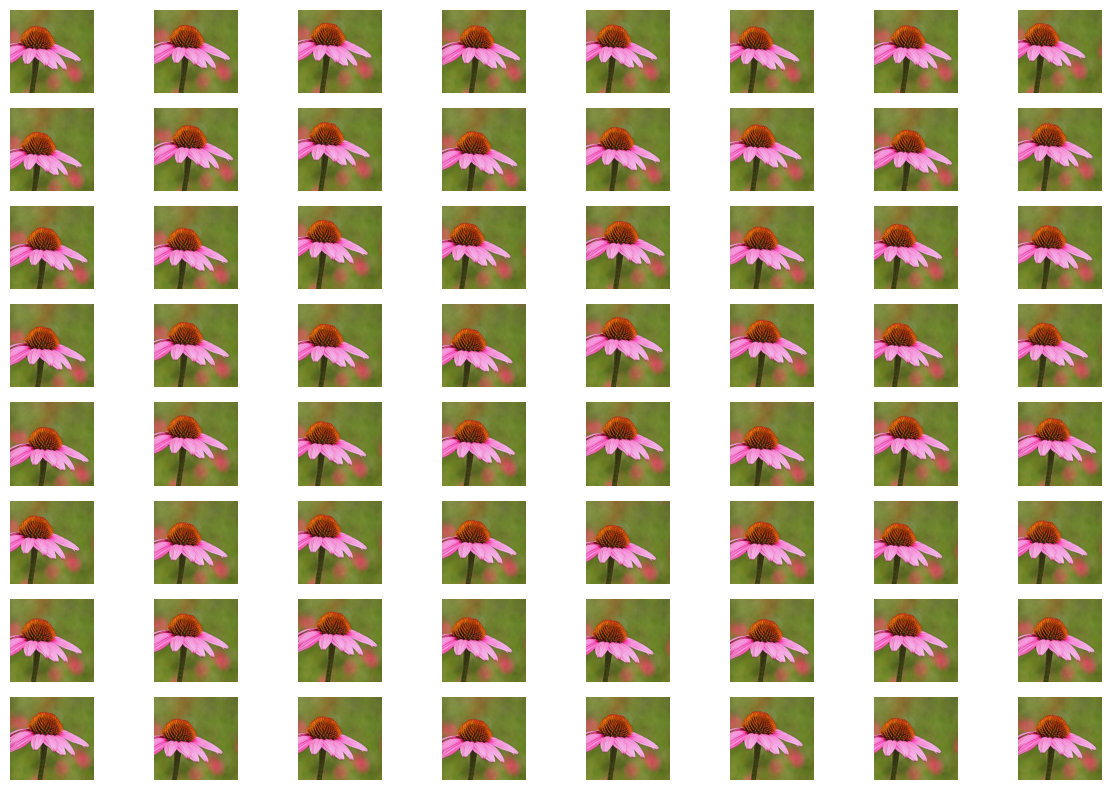

In [12]:
number = 8
fig, ax = plt.subplots(number, number)
ax = ax.flatten()

for n, i in enumerate(many_image_portions_for_viz):
    if n == 55:
        #break
        for j in range(int(number * number)):
            ax[j].imshow(F.to_pil_image(i[j]))
            ax[j].axis('off')
        
        break

plt.tight_layout()

#### 2.2 Compiling the augmentation-on-the-fly function

In [13]:
def subtract_mean_activity(
    tensor,
    mean_activity=mean_activity_all_training,
):
    if mean_activity.shape != (3, 256, 256):
        mean_activity = mean_activity.permute(2, 0, 1)
    
    mean_activity_subtracted_tensor = tensor - mean_activity
    return mean_activity_subtracted_tensor

def add_pca_multiples(
    tensor,
    random_alphas,
    eigenvectors=training_eigenvectors,
    eigenvalues=training_eigenvalues,
):
    multiple_to_add = eigenvectors @ (eigenvalues * random_alphas)
    multiple_to_add_reshaped = multiple_to_add.reshape(3, 1, 1)
    
    tensor_w_multples_added = tensor + multiple_to_add_reshaped
    return tensor_w_multples_added

def extract_augment_image_portions(
    image_path,
    subtract_mean_activity=subtract_mean_activity,
    add_pca_multiples=add_pca_multiples,
):
    """
    This function randomly crops 1024 unique 224x224 sized portions of the input image, 
    horizontally flips them, and returns a list containing 2048 images as PyTorch tensors.

    This function can be generalized further to crop N x N portions, or randomly sample D
    amount of top-left corners.
    """
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))

    # performing mean activity/image subtraction
    image_as_tensor_subracted = subtract_mean_activity(image_as_tensor)

    # defining the the top left corners that can be sampled
    # and then randomly sampling 1024 of them
    left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
    random_corners = random.sample(left_top_corners, 1024)
    
    image_portions = [
        image_as_tensor_subracted[:, i:i + 224, j:j + 224] for i, j in random_corners
    ] 
    
    # adding PCA multiples to the images
    # defining the alpha here so that a new set of numbers are drawn for each image
    # as done in the paper by the authors
    new_random_alpha = torch.from_numpy(
        np.random.normal(loc=0, scale=0.1, size=3)
    ).to(torch.float32)
    
    image_portions = [add_pca_multiples(i, new_random_alpha) for i in image_portions]

    # flipping the 1024 images and adding them to the list
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )

    # converting all image portions to float32
    image_portions = [i.to(torch.float32) for i in image_portions]

    return image_portions

# taking a small portion of the training set
items_in_subset = 12
training_images_processed_path_subset = training_images_processed_path[:items_in_subset]

# mapping the function to a small subset
many_image_portions_for_training = map(
    extract_augment_image_portions,
    training_images_processed_path_subset
)

# creating an iter object of all the image paths
#iter_processed_training_images = iter(training_images_processed_path)

In [14]:
size_in_bytes = torch.vstack(next(many_image_portions_for_training)).element_size() \
                * torch.vstack(next(many_image_portions_for_training)).nelement()
size_in_gbs = size_in_bytes / (1024 ** 3)

print(
    f"The estimated total size of {(items_in_subset / len(training_images_processed_path)):.5f}th "
    f"of the augmented dataset is {(items_in_subset * size_in_gbs):.2f} gigabytes."
)
print(
    f"The estimated total size of the augmented training set is "
    f"{(len(training_images_processed_path) * size_in_gbs / (1024 * 10)):.2f} terabytes."
)

The estimated total size of 0.00001th of the augmented dataset is 13.78 gigabytes.
The estimated total size of the augmented training set is 141.47 terabytes.


In [15]:
# the wordnet IDs were mapped to values between 0-999 
# the latter will be used as the training labels
# loading a file created in section 4 of augment_ingest.ipynb

labels_w_information = pl.read_csv("./images/labels_w_information.csv")
labels_w_information.columns

['image_path',
 'image_name',
 'wnid',
 'wnid_minus_n',
 'ILSVRC2010_ID',
 'made_up_label',
 'synset',
 'lemmas']

In [16]:
training_labels_for_CEloss = labels_w_information["made_up_label"].to_list()
len(training_labels_for_CEloss)

1261405

#### 2.3 Using a simpler augmentation function for the trial run, creating a custom `Dataset`, randomly sampling a subset of the training set, and writing the training loop

In [17]:
def extract_augment_image_portions_temp(
    image_path,
    subtract_mean_activity=subtract_mean_activity,
    add_pca_multiples=add_pca_multiples,
):
    """
    TEMPORARY FUNCTION FOR THE TRIAL RUN

    THIS FUNCTION TAKES A 224 x 224 CENTER CROP FOR SIMPLICITY
    FOR THE TRIAL RUN, I WANTED TO CHECK IF THE MODEL IS ABLE TO LEARN OK
    """
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))

    # performing mean activity/image subtraction
    image_as_tensor_subracted = subtract_mean_activity(image_as_tensor)

    start_x = (256 - 224) // 2
    start_y = (256 - 224) // 2

    # center cropping the tensor
    cropped_tensor = image_as_tensor_subracted[:, start_x:start_x + 224, start_y:start_y + 224]
    
    # adding PCA multiples to the images
    # defining the alpha here so that a new set of numbers are drawn for each image
    # as done in the paper by the authors
    new_random_alpha = torch.from_numpy(
        np.random.normal(loc=0, scale=0.1, size=3)
    ).to(torch.float32)
    
    pca_added_tensor = add_pca_multiples(cropped_tensor, new_random_alpha)

    final_tensor = pca_added_tensor.to(torch.float32)

    return final_tensor

def transform_labels(
    single_label
):
    return [torch.tensor(single_label)] * 2048

In [18]:
class AlexNetTrainingSubset(Dataset):
    def __init__(
        self, 
        labels=training_labels_for_CEloss,
        image_directory=training_images_output_path, 
        image_names=training_images_processed_names,
        transform=extract_augment_image_portions, #extract_augment_image_portions_temp, 
        target_transform=transform_labels
    ):
        self.img_labels = labels
        self.image_directory = image_directory
        self.image_names = image_names
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_directory, self.image_names[index])
        label = self.img_labels[index]
        
        images = self.transform(img_path)
        #images_stacked = torch.stack(images)
        
        labels = self.target_transform(label)
        #labels_stacked = torch.stack(labels)
        
        return images, labels[0]

In [19]:
# below, I am sampling only labels with greater than 1200 examples and then randomly selecting 25 labels
labels_thousand_plus = [
    label for label, count in Counter(training_labels_for_CEloss).items() 
    if count >= 1200
]
labels_thousand_plus_subset = random.sample(labels_thousand_plus, k=25)

# mapping the subset to numbers between 0-24
# this is needed for the CE loss function
labels_subset_mapped = {
    original_label: new_label for original_label, new_label
    in zip(labels_thousand_plus_subset, range(0, len(labels_thousand_plus_subset)))
}

# a dictionary of indices as keys with the 25 randomly selected labels as values
label_w_index = {
    index: label for index, label 
    in zip(range(0, len(training_labels_for_CEloss)), training_labels_for_CEloss)
    if label in labels_thousand_plus_subset
}

# randomly selecting k of those indices which are then used to 
# select the subset of inputs and labels in training_subset
random_indices = random.sample(list(label_w_index.keys()), k=int(256 * 128))

In [20]:
# loading the validation IDs provided in the Image Net devkit
validation_ILSVRC2010_IDs = []

with open("./devkit-1.0/data/ILSVRC2010_validation_ground_truth.txt") as file:
    while line := file.readline():
        validation_ILSVRC2010_IDs.append(int(line.rstrip()))

In [21]:
# the difference between ILSVRC2010_ID and WNIDs is 1 
# because of how they were mapped previously
diff_check = labels_w_information["ILSVRC2010_ID"] - labels_w_information["made_up_label"]
print([i for i in diff_check if i != 1])

[]


In [22]:
# converting the IDs to labels for the validation data
validation_true_labels = [i - 1 for i in validation_ILSVRC2010_IDs]

validation_subset_25_labels = {
    image_name: label for image_name, label 
    in zip(validation_images_processed_names, validation_true_labels) 
    if label in labels_thousand_plus_subset
}

In [23]:
# sampling based on the random indices but storing 
# the 0-24 values using the labels_subset_mapped dictionary
training_labels_subset_sampled_converted = [
    labels_subset_mapped.get(training_labels_for_CEloss[i]) for i in random_indices
]

# sampling image names based on the random indices
training_image_names_subset_sampled = [
    labels_w_information["image_name"][i] for i in random_indices
]


training_subset = AlexNetTrainingSubset(
    labels=training_labels_subset_sampled_converted,
    image_directory=training_images_output_path, 
    image_names=training_image_names_subset_sampled,
    transform=extract_augment_image_portions_temp, 
    target_transform=transform_labels
)

validation_labels_subset_sampled_converted = [
    labels_subset_mapped.get(i) for i in list(validation_subset_25_labels.values())
]

validation_subset = AlexNetTrainingSubset(
    labels=validation_labels_subset_sampled_converted, 
    image_directory=validation_images_output_path, 
    image_names=list(validation_subset_25_labels.keys()),
    transform=extract_augment_image_portions_temp, 
    target_transform=transform_labels
)

In [24]:
training_set = AlexNetTrainingSubset(
    labels=training_labels_for_CEloss,
    image_directory=training_images_output_path, 
    image_names=training_images_processed_names,
    transform=extract_augment_image_portions_temp, 
    target_transform=transform_labels
)

train_loader = DataLoader(
    training_set, 
    batch_size=256,
    shuffle=True,
    num_workers=0
)

print(len(train_loader))

train_loader_iter = iter(train_loader)

4928


In [25]:
for i in next(train_loader_iter):
    print(i.shape)

torch.Size([256, 3, 224, 224])
torch.Size([256])


In [26]:
# to check if the Dataset outputs are sound
for n, item in enumerate(training_subset):
    print(item[0].shape)
    #print(len(item[0]), len(item[1]))
    #print(item[0].shape)
    #print(item[0][0])
    #print(item[1][0])

    if n == 0:
        break

torch.Size([3, 224, 224])


**The output from the custom `Dataset` seems correct.** I also tested it with the `extract_augment_image_portions` function (which increases the dataset by 2048x), and the outputs of that also looked sound. 

I am not using `extract_augment_image_portions` for the trial run because it returns 2048 of the same image during each iteration, so diversity of samples per epoch ends up being really low (*note 1*). I have an idea to create a sampling-index-dictionary thing to remedy this and ensure that each batch contains *B* unique randomly cropped images; I will devise this in the next section. Presently, I want to ensure that model training and learning proceed successfully.

In [27]:
train_subset_loader = DataLoader(
    training_subset, 
    batch_size=256,
    shuffle=True, 
    num_workers=0
)

validation_subset_loader = DataLoader(
    validation_subset, 
    batch_size=256,
    shuffle=True,
    num_workers=0
)

In [28]:
initial_learning_rate = 0.01
momentum=0.9
weight_decay=0.0005

# instantiating the model and applying the custom weights and biases
alexnet = AlexNet(number_of_classes=25)
alexnet.apply(initialize_weights_biases)

# defining the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( # Adam
    alexnet.parameters(), 
    lr=initial_learning_rate,
    momentum=momentum, # for SGD
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="max",
    factor=0.1,
    patience=10,
    threshold=0.01,
    cooldown=4,
    min_lr=initial_learning_rate / 1000
)

steps_to_take = len(train_subset_loader)
print(steps_to_take)

128


In [29]:
# moving the device to one of the devices doesn't work for model parallelism
#alexnet = alexnet.to(device1)
#criterion = criterion.to(device1)

num_epochs = 75

In [30]:
# create string with date or date & time for the log file name
current_date_formatted = date.today().strftime("%Y%m%d")
#current_datetime_formatted = datetime.today().strftime("%Y%m%d_%H_%M")

log_file_name = f"./logs/training_log_{current_date_formatted}.csv"

def write_to_csv(epoch, train_loss, train_acc, val_loss, val_acc, lr):
    with open(log_file_name, "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr])

with open(log_file_name, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "epoch", 
        "training_loss", 
        "training_accuracy",
        "validation_loss", 
        "validation_accuracy",
        "learning_rate",
    ])

In [ ]:
for epoch in range(num_epochs):
    # training block
    
    # layers like dropout behave differently during training and validation
    # so, setting the model to training mode
    alexnet.train()
    
    running_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_subset_loader:
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # backpropagation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # computing training metrics
    epoch_loss = running_loss / len(train_subset_loader)
    epoch_acc = correct_train / total_train
    
    # validation block
    alexnet.eval()
    correct_val = 0
    total_val = 0
    val_loss_count = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in validation_subset_loader:
            val_inputs = val_inputs.to(device1)
            val_labels = val_labels.to(device1)
            
            val_outputs = alexnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_loss_count += val_loss.item()
            
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()
    
    # computing validation metrics
    val_epoch_loss = val_loss_count / len(validation_subset_loader)
    val_epoch_acc = correct_val / total_val

    # executing the learning rate (lr) scheduler and saving the current lr value
    scheduler.step(val_epoch_acc)
    current_lr = scheduler.get_last_lr()[0]

    print(
        f"{str(epoch + 1).zfill(2)}/{num_epochs}, "
        f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}, "
        f"Learning Rate: {current_lr}"
    )

    write_to_csv(epoch + 1, epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc, current_lr)

print(f"Trial training done! Loss and accuracy values were saved to {log_file_name}")

In [ ]:
#for name, child in alexnet.named_modules():
#    if isinstance(child, nn.Module):
#        child.register_forward_hook(
#            lambda m, inp, out, name=name: print('{} output shape {}'.format(name, out.shape))
#        )
#
#x = torch.randn(128, 3, 224, 224)
#output = alexnet(x)

In [30]:
# saving the model and the optimizer states
torch.save(alexnet.state_dict(), f"./logs/trial_runs/1_alexnet_wb_{current_date_formatted}.pt")
torch.save(optimizer.state_dict(), f"./logs/trial_runs/1_alexnet_optimizer_{current_date_formatted}.pt")

#### 2.4 Plotting the results 

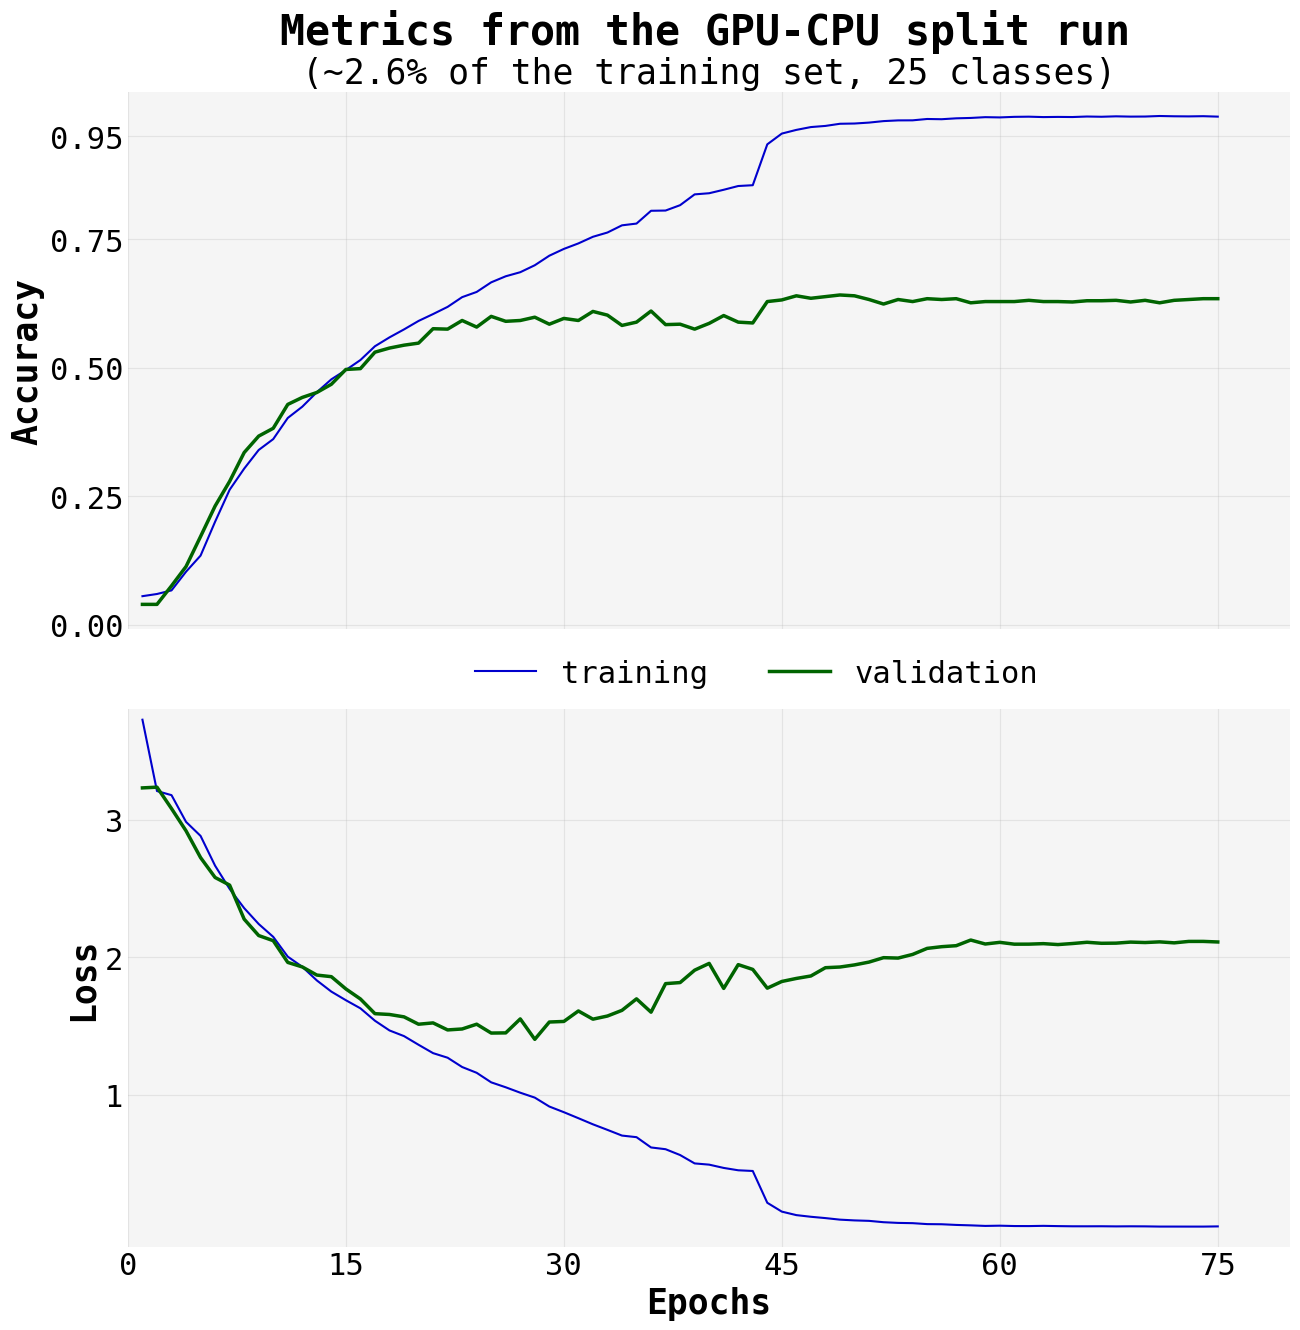

In [34]:
live_loss_accuracy = pl.read_csv("./logs/training_log_20240807.csv")

fig, ax = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)

ax[0].plot(
    live_loss_accuracy["epoch"],
    live_loss_accuracy["training_accuracy"],
    lw=1.5,
    color="mediumblue",
    label="training",
)

ax[0].plot(
    live_loss_accuracy["epoch"],
    live_loss_accuracy["validation_accuracy"],
    lw=2.5,
    color="darkgreen",
    label="validation",
)

ax[0].set_ylabel("Accuracy", fontsize=25, fontweight="semibold")
ax[0].set_yticks([0.00, 0.25, 0.50, 0.75, 0.95])

ax[0].set_title(
    "(~2.6% of the training set, 25 classes)",
    fontsize=25
)

plt.suptitle(
    "Metrics from the GPU-CPU split run", 
    fontsize=30, 
    x=0.51, 
    y=0.935, 
    fontweight="semibold"
)

ax[1].plot(
    live_loss_accuracy["epoch"],
    live_loss_accuracy["training_loss"],
    lw=1.5,
    color="mediumblue",
    label="training",
)

ax[1].plot(
    live_loss_accuracy["epoch"],
    live_loss_accuracy["validation_loss"],
    lw=2.5,
    color="darkgreen",
    label="validation",
)

ax[1].set_ylabel("Loss", fontsize=25, fontweight="semibold")
ax[1].set_xlabel("Epochs", fontsize=25, fontweight="semibold")
ax[1].set_xticks([0, 15, 30, 45, 60, 75,])
ax[1].set_yticks([1, 2, 3])

ax[1].set_xlim(0, 80)
ax[1].set_ylim(-0.1, 3.8)

for i in range(2):
    ax[i].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax[i].tick_params(axis='both', which='both', length=0, labelsize=22)
    ax[i].grid(alpha=0.25)


fig.legend(
    ['training', 'validation'], 
    bbox_to_anchor=(0.75, 0.52), 
    ncol=2, 
    fontsize=22, 
    frameon=False,
)

fig.subplots_adjust(hspace=0.15)
plt.show()

#plt.savefig(
#    "./plots/metrics_second_trial_run.png",
#    dpi=600,
#    bbox_inches="tight",
#)

### 3. Updated versions of the 2048x-ed image augmentation scheme

In the paper, the author's randomly sample 1024 portions of an image and then flip all those images. Doing so for all the images increases the training set by a factor of 2048. Initially, I constructued the dataset class such that 2048 versions of the same image would be passed by the `Dataloader` one-by-one. However, this is not ideal for reasons in *[note 1]* above.

#### 3.1 "Ledger" Method
One solution that I was inclined towards is maintaining a _ledger_ that tracks the amount of times a particular image has been used for training. A few ways of doing so:
1. A dictionary with the image names as keys and a list of randomly sampled indices as values. The indices would be taken from this list until they were all exhausted.
2. A dictionary with image names as keys and a count as values. The count starts from 0, and is incremented each time a particular image is used (although, the issue here is that the same portion of a particular image may be sampled _n_ times, instead of 1024 unique portions sampled each time).

Maintaining such a ledger is expensive, and the interface between the dataset class and such dictionaries could get complicated. So, the next best thing I could come up with is encoding all that information in the names being passed. That is, the list of image names being passed would have the format `{image name}-{left most image corner}-{true label}-{flip or not flip}`. An actual example: `n03982430_20160.JPEG-(3, 1)-1-f`. The extraction of the image, it's cropped portion, label, and orientation could be done inside the dataset.

Testing that below:

In [26]:
"name_(3, 1)"

'name_(3, 1)'

In [27]:
(training_images_processed_names[0] + "-(3, 1)-f").split("-")

['n03982430_20160.JPEG', '(3, 1)', 'f']

In [28]:
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
label_from_name = {name: label for name, label in zip(labels_w_information["image_name"], labels_w_information["made_up_label"])}
orig_flip_list = ["orig"] * 1024 + ["flip"] * 1024

In [29]:
names_labels_coord_o_test = []

for image_name in training_images_processed_names[:1]:
    random_corners_doubled = 2 * random.sample(left_top_corners, 1024)
    label = label_from_name.get(image_name)
    
    extended_names = [
        f"{image_name}-{label}-{corner}-{orientation}" 
        for corner, orientation 
        in zip(random_corners_doubled, orig_flip_list)
    ]
    names_labels_coord_o_test.extend(extended_names)

In [30]:
some_array = np.array([100] * 2048 * 1261405, dtype=np.uint8)

In [31]:
import sys
sys.getsizeof(some_array) / 1024 ** 3

2.40593920648098

##### **3.1.1 Saving only the corners and the orientation**

The issue above is the size of the list, which seems obvious upon reflection. The list with names has 1.2 million+ entries. When this list is 2048x-ed, it occupies ~20 gigabytes in memory. I could save such a file and then use `np.memmap` or something similar to read it lazily. However, I think that only saving the `{left most image corner}-{flip or not flip}` in a `uint8` or `uint16` format could be memory efficient, and would *not* require creating and storing an absurdly large file with `2048 * 1261405 = 2,583,357,440` strings.

- I will use `0` for flipping or a `1` for not flipping
- There is no need to save the image names again; I could just loop the list of names 2048 times
- The labels can be easily retrieved using a dictionary
- Not saving the names and labels also means less number of digits to save, so easier to store the integers as `uint16` $\to$ lower memory usage
- Inside the Dataset class, I will read the number as a string and retrieve the coordinate and the flip/not flip boolean and pass that to a modified augmentation function

I want to gauge how much memory an array with this information would consume —

In [28]:
# defining all top left corners and a sequence of flip/don't flip integers which will read as bools
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
orig_flip_list = [0, 1] * 2048

In [29]:
# sanity checking that the highest coordinate is only two digits long
# even if one coordinate is three digit, then the combined integer would 
# fall outside the int16 range
max([max(i) for i in left_top_corners])

32

In [30]:
# stacking coordinates and orientations for 1/1000th of the training set
stacked_array = np.array([0], dtype=np.uint16)

for _ in tqdm(range(int(len(training_images_processed_names) / 1000))):
    random_corners_doubled = 2 * random.sample(left_top_corners, 1024)
    
    to_stack = np.vstack([
        np.array(int(f"{corner[0]}{corner[1]}{orientation}"), dtype=np.uint16)
        for corner, orientation
        in zip(random_corners_doubled, orig_flip_list)
    ])

    stacked_array = np.vstack((stacked_array, to_stack))

stacked_array = np.delete(stacked_array, 0)

100%|██████████████████████████████████████| 1261/1261 [00:01<00:00, 648.07it/s]


In [31]:
print(f"Size of the array: {1000 * stacked_array.nbytes / (1024 ** 3):.3f} GB")
del stacked_array

Size of the array: 4.810 GB


Is there a major size difference if I store the coordinates and the 0/1 separately? (Then I won't have to read the number as a string and do conversions...)

In [32]:
stacked_array = np.array([0], dtype=np.uint8)

for _ in tqdm(range(int(len(training_images_processed_names) / 1000))):
    random_corners_doubled = 2 * random.sample(left_top_corners, 1024)
    
    to_stack = np.vstack([
        np.array(
            [corner[0], corner[1], orientation], 
            dtype=np.uint8
        ).reshape(3, 1)
        for corner, orientation
        in zip(random_corners_doubled, orig_flip_list)
    ])

    stacked_array = np.vstack((stacked_array, to_stack))

stacked_array = np.delete(stacked_array, 0)

100%|██████████████████████████████████████| 1261/1261 [00:01<00:00, 681.43it/s]


In [33]:
print(f"Size of the array: {1000 * stacked_array.nbytes / (1024 ** 3):.3f} GB")

Size of the array: 7.215 GB


**Okay, it is clearly better to save it has a N x 1 array.**

In [34]:
# replicating the first N x 1 approach with torch tensors
stacked_tensor = torch.tensor([0], dtype=torch.uint16)

for _ in tqdm(range(int(len(training_images_processed_names) / 1000))):
    random_corners_doubled = 2 * random.sample(left_top_corners, 1024)
    
    to_stack = torch.vstack([
        torch.tensor([int(f"{corner[0]}{corner[1]}{orientation}")], dtype=torch.uint16)
        for corner, orientation in zip(random_corners_doubled, orig_flip_list)
    ])
    
    stacked_tensor = torch.vstack((stacked_tensor, to_stack))

print(1000 * stacked_tensor.element_size() * stacked_tensor.nelement() / (1024 ** 3))

100%|██████████████████████████████████████| 1261/1261 [00:06<00:00, 208.61it/s]

4.810335114598274


Numpy arrays are ever so slightly faster than tensors at this operation, and the amount of space required by both is nearly identical.

In [35]:
value_to_delete = 65534
array_size = int(len(training_images_processed_names) / 1000)
corners_orientation = np.array(value_to_delete, dtype=np.uint16)

for num in tqdm(range(array_size)):
    random_corners_doubled = 2 * random.sample(left_top_corners, 1024)
    
    to_stack = np.vstack([
        np.array(int(f"{corner[0]}" + f"{corner[1]}".zfill(2) + f"{orientation}"), dtype=np.uint16)
        for corner, orientation in zip(random_corners_doubled, orig_flip_list)
    ])

    corners_orientation = np.vstack((corners_orientation, to_stack))

corners_orientation = np.delete(corners_orientation, 0)

100%|██████████████████████████████████████| 1261/1261 [00:02<00:00, 612.21it/s]


In [36]:
len(corners_orientation) == int(len(training_images_processed_names) / 1000) * 2048

True

In [37]:
# sample_string = list(str("320").zfill(5))
# print(sample_string)
#
# if sample_string[:2] == list("00"):
#    sample_string[1], sample_string[2] = sample_string[2], sample_string[1]
#
# print(sample_string[0] + sample_string[1], sample_string[2] + sample_string[3], sample_string[4])

In [38]:
# value_to_delete = 65534
# array_size = int(len(training_images_processed_names) / 10)
# corners_orientation = np.array([value_to_delete] * 2048, dtype=np.uint16).reshape(2048, 1)
# #corners_orientation = np.array([value_to_delete], dtype=np.uint16)
# 
# for num in tqdm(range(array_size)):
#     random_corners = random.sample(left_top_corners, 1024)
#     random_corners_doubled = [item for item in random_corners for i in range(2)]
#     
#     #to_stack = [
#     #    np.array([corner[0], corner[1], orientation], dtype=np.uint16)
#     #    for corner, orientation in zip(random_corners_doubled, orig_flip_list)
#     #]
# 
#     to_stack = np.vstack([
#         np.array(int(f"{corner[0]}{corner[1]}{orientation}"), dtype=np.uint16)
#         for corner, orientation
#         in zip(random_corners_doubled, orig_flip_list)
#     ])
# 
#     corners_orientation = np.hstack((corners_orientation, to_stack))
# 
# corners_orientation = np.delete(corners_orientation, (0), axis=1)
# corners_orientation

In [39]:
# 1000 * corners_orientation.nbytes / 1024 ** 3

In [40]:
# corners_orientation[:, 0]

In [41]:
# np.array([value_to_delete] * 3, dtype=np.uint16).reshape(3, 1)

In [42]:
label_from_name = {
    name: [label, index] for name, label, index in zip(
        labels_w_information["image_name"], 
        labels_w_information["made_up_label"],
        range(0, len(labels_w_information["image_name"])),
    )
}

In [43]:
label_from_name.get("n03982430_20160.JPEG")[0]

742

Below, I was testing if saving the coordinates and flips as float16 was better (there is a slight advantage of having the point "." as a separator). `float16` is, in fact, worse for this task due to numerical stability issues (numbers beyond the hundredth digit aren't properly maintained). 

In [44]:
# left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
# orig_flip_list = [0, 1] * 1024
# 
# array_size = int(len(training_images_processed_names) / 1000)
# corners_orientation = np.empty((2048, 0), dtype=np.float16)
# 
# for _ in tqdm(range(array_size)):
#     random_corners = random.sample(left_top_corners, 1024)
#     random_corners_doubled = np.repeat(random_corners, 2, axis=0)
# 
#     to_stack = np.array(
#         [
#             np.float16(f"{orientation}" + "." + f"{corner[0]}".zfill(2) + f"{corner[1]}".zfill(2))
#             for corner, orientation in zip(random_corners_doubled, orig_flip_list)
#         ], 
#         dtype=np.float16
#     ).reshape(-1, 1)
# 
#     corners_orientation = np.hstack((corners_orientation, to_stack))
# 
# corners_orientation

In [45]:
# 1000 * corners_orientation.nbytes / 1024 ** 3

In [46]:
# left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
# orig_flip_list = [0, 1] * 544 + [1]
# 
# for c, o  in zip(left_top_corners, orig_flip_list):
#     value = f'{np.float16(f"{o}" + "." + f"{c[0]}".zfill(2) + f"{c[1]}".zfill(2)):.4f}'
#     if len(value) != 6:
#         print(c, o)
#         #break
# 
# for c, o  in zip(left_top_corners, orig_flip_list):
#     value = np.float16(f"{o}" + "." + f"{c[0]}".zfill(2) + f"{c[1]}".zfill(2))
#     if len(value) != 6:
#         print(c, o)
#         #break

In [47]:
# value = f'{np.float16("0." + f"{0}".zfill(2) + f"{20}".zfill(2) + f"{1}"):.5f}'
# print(value)

In [48]:
# (value := float(f'{np.float16("0." + f"{0}".zfill(2) + f"{0}".zfill(2) + f"{1}"):.5f}'))

##### **3.1.2 Sanity check: are all possible corners + orientation values being stored properly and uniquely?**

In [49]:
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
orig_flip_list = [0, 1] * 544 + [1]

some_list = []

for c, o  in zip(left_top_corners, orig_flip_list):
    value = str(np.int16(f"{c[0]}".zfill(2) + f"{c[1]}".zfill(2) + f"{o}")).zfill(5)
    some_list.append(value)
    if len(value) != 5:
        print(c, o)
        break

In [50]:
len(some_list) == len(np.unique(some_list))

True

##### **3.1.3 Saving the corners and the orientation as `uint16` values**

In [51]:
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]
orig_flip_list = [0, 1] * 1024

array_size = int(len(training_images_processed_names) / 1000)
corners_orientation = np.ones((2048, 1), dtype=np.uint16).reshape(-1, 1)

for _ in tqdm(range(array_size)):
    random_corners = random.sample(left_top_corners, 1024)
    random_corners_doubled = np.repeat(random_corners, 2, axis=0)

    to_stack = np.array(
        [int(f"{corner[0]}" + f"{corner[1]}".zfill(2) + f"{orientation}") 
         for corner, orientation in zip(random_corners_doubled, orig_flip_list)], 
        dtype=np.uint16
    ).reshape(-1, 1)

    corners_orientation = np.hstack((corners_orientation, to_stack))

corners_orientation
print(np.round(1000 * corners_orientation.nbytes / 1024 ** 3, 3), "gigabytes")

100%|██████████████████████████████████████| 1261/1261 [00:01<00:00, 728.43it/s]

4.814 gigabytes


In [52]:
corners_orientation = corners_orientation[:, 1:]
corners_orientation

array([[ 8080, 27220, 19040, ..., 24320, 31320, 29260],
       [ 8081, 27221, 19041, ..., 24321, 31321, 29261],
       [ 2100,  1260, 18260, ..., 16180, 18260, 27160],
       ...,
       [ 8321,  1041, 12181, ..., 25271,  9271,  9191],
       [20300,  6210, 14010, ...,  4110, 25160,  2160],
       [20301,  6211, 14011, ...,  4111, 25161,  2161]], dtype=uint16)

In [53]:
corners_orientation.shape

(2048, 1261)

The approach above will work, but the best I can do with it is create a ~4.8 GB, 2048 x 1261405 sized array where each row represents a particular left-top image corner + orientation and each column represents 2048 variations of the same image. Inside a custom dataset class, the index of the image name could be used to choose a column, and another index could be used to select a particular value from that column. If it is `301`, converting this to a string with five elements (`.zfill(2)`) would make it `string = 00301`, which could be split — `left_top_edge = (string[:2], string[2:5])` and `flip = True if string[-1:] == 1 else False` — and passed to the augmentation function which would crop a 224x224 from the given coordinate and flip the image. **This is an okay solution but it is inelegant maybe and a bit clumsy** — it still requires some disk space, indexing and tracking.

The bottleneck I was facing is generating a sequence of 1024 *unique* randomly chosen corners for every single image & keeping track of them as they were passed through the dataset. I am saving an additional `0` or `1` for the flips, but there is probably a way to encode this into the dataset class and halve the size of the array and reduce it to 2.4 GBs, which would be an improvement. 

I turned to [Claude](Claude.ai) for help and the suggestion was to use hashlibs **$\to$ Use an image name (or path) to generate a hash value, and apparently since the hash for a string is always unique $\to$ create a random number from the hash which will also always be unique $\to$ the sequence of randomly chosen corners will always be identical!**

This seems like The solution to what I considered was an unsolvable constraint!

#### 3.2 Hashlib method

##### 3.2.1 Basic exploration + tests

In [54]:
sample_hash = hashlib.md5(f"one_string".encode('utf-8'))
sample_hash = sample_hash.digest()
print(sample_hash)

b'U\x9c\xd9Q\x19{\x9f\xee\x86\xf3F\x96H\x95\x1a\xf9'


In [55]:
int.from_bytes(sample_hash)

113798785659901016752433984736547117817

In [56]:
# testing hash -> same random number generation
random_nums = []

for _ in range(int(1e6)):
    random_nums.append(int.from_bytes(sample_hash))

print(np.mean(random_nums) == int.from_bytes(sample_hash))

True


In [57]:
# testing reliability

mistakes = 0
rng = np.random.default_rng(random_nums[0])
rng2 = np.random.default_rng(random_nums[0])
for i in tqdm(range(int(1e6))):
    arr1 = rng.integers(0, 1)
    arr2 = rng2.integers(0, 1)
    
    if not np.array_equal(arr1, arr2):
        mistakes += 1

print(mistakes)

100%|█████████████████████████████| 1000000/1000000 [00:03<00:00, 298300.42it/s]

0


In [58]:
# testing choice consistency
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]

mistakes = 0
rng = np.random.default_rng(random_nums[0])
rng2 = np.random.default_rng(random_nums[0])
for i in tqdm(range(int(1e5))):
    arr1 = rng.choice(left_top_corners)
    arr2 = rng2.choice(left_top_corners)
    
    if not np.array_equal(arr1, arr2):
        mistakes += 1

print(mistakes)

100%|█████████████████████████████████| 100000/100000 [00:27<00:00, 3699.73it/s]

0


Checks out, of course!

`.choice()` is ~100x slower than generating `.integers()`, so it would be better to use the latter to generate tuples between 0 - 32 (since all images are 256 x 256, and the crop is 224 x 224, `256 - 224 = 32` is the maximum value for the left-top corner coordinate).

In [59]:
rng = np.random.default_rng(random_nums[0])
rng.integers(0, 32 + 1, size=(10, 2))

array([[30, 18],
       [30, 25],
       [28, 28],
       [12, 22],
       [29,  3],
       [ 4, 20],
       [31, 22],
       [24, 26],
       [14, 31],
       [23,  8]])

##### **3.2.2 Modifying the augmentation function & the Dataset class to work with random numbers generated from hashes**

In [60]:
def extract_augment_image_co(
    image_path,
    corners,
    orientation_bool,
    subtract_mean_activity=subtract_mean_activity,
    add_pca_multiples=add_pca_multiples,
):
    """
    This function subtracts the mean activity of all training images from the image,
    crops a 224 x 224 image portion based on the provided left-top coordinate, 
    adds PCA multiples to R, G, & B pixel values of the image, and optionally 
    horizontally flips the tensor. 
    """
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))

    # performing mean activity/image subtraction
    image_as_tensor_subracted = subtract_mean_activity(image_as_tensor)

    # retrieving the left-top corners and cropping the image 
    start_x, start_y = corners
    cropped_tensor = image_as_tensor_subracted[:, start_x:start_x + 224, start_y:start_y + 224]
    
    # adding PCA multiples to the images
    # defining the alpha here so that a new set of numbers are drawn for each image
    # as done in the paper by the authors
    new_random_alpha = torch.from_numpy(
        np.random.normal(loc=0, scale=0.1, size=3)
    ).to(torch.float32)
    
    pca_added_tensor = add_pca_multiples(cropped_tensor, new_random_alpha)

    # optionally flipping the tensor based on the boolean value
    if orientation_bool:
        pca_added_tensor = torch.flip(pca_added_tensor, dims=(2,))

    # converting to float32
    final_tensor = pca_added_tensor.to(torch.float32)

    return final_tensor

In [61]:
# dictionary with names and labels
label_from_name_dictionary = {
    name: label for name, label 
    in zip(labels_w_information["image_name"], labels_w_information["made_up_label"])
}

In [62]:
class AlexNetTrainingSet(Dataset):
    def __init__(
        self, 
        image_directory=training_images_output_path, 
        image_names=labels_w_information["image_name"],
        label_from_image_name=label_from_name_dictionary,
        transform=extract_augment_image_co,
        total_augmentations=2048,
        debug=False,
    ):
        self.image_directory = image_directory
        self.image_names = image_names
        self.label_from_image_name = label_from_image_name
        self.transform = transform
        self.total_augmentations = total_augmentations
        self.debug = debug

    def __len__(self):
        # here, every successive 2048 indices corresponds to one image
        return len(self.image_names) * self.total_augmentations

    def __getitem__(self, index):
        # getting the image index; example: for index == 4000, 
        # index // 2048 = 2, so the second image in the list
        image_index = index // self.total_augmentations

        # this index ensures that a unique corner is picked every time
        # as index won't be repeated -> the remainder will always be unique
        augment_index = index % self.total_augmentations

        # assigning the image name, label, and path
        image_name = self.image_names[image_index]
        label = self.label_from_image_name.get(image_name)
        
        # get parameters for augmentation
        corner_coord, flip_bool = self.augment_params(image_name, augment_index)

        # getting the image path and a 224 x 224 random crop
        image_path = os.path.join(self.image_directory, image_name)
        augmented_image = self.transform(
            image_path,
            corner_coord,
            flip_bool,
        )
        
        return augmented_image, label

    def augment_params(self, image_name, augment_index):
        # getting a unique hash value from image name -> unique random seed
        image_hash = hashlib.md5(f"{image_name}".encode('utf-8')).digest()
        rng_from_hash = np.random.default_rng(int.from_bytes(image_hash))
        
        # 256 - 224 = 32 is the max value to crop a 224 x 224 image
        all_coords = rng_from_hash.integers(0, 32 + 1, size=(self.total_augmentations, 2))

        # sampling a left-top corner coordinate
        corner_coord = all_coords[augment_index]
        
        # if the augment index is even, flip, otherwise, don't
        flip_bool = augment_index % 2 == 0

        #if debug:
        return corner_coord, flip_bool

In [63]:
sample_set = AlexNetTrainingSet(
    image_names=labels_w_information["image_name"],
    total_augmentations=2048,
)

In [64]:
sample_loader = DataLoader(
    sample_set, 
    batch_size=128,
    shuffle=True, 
    num_workers=0
)

In [55]:
sample_loader_iter = iter(sample_loader)

In [ ]:
for thing in next(sample_loader_iter):
    print(thing.shape)
    #plt.imshow(thing[0].to(torch.uint16).permute(1, 2, 0))
    #break

In [65]:
print(len(sample_loader))

20182480


When trying to print just one input and label, the kernel kept crashing; I initially thought it was because of the entire list of names being passed while instantiating the dataset, however, it was actually crashing due to the enourmous `__len__` value that was being returned.

The length of the dataloader prompted me to do a little back-of-the-envelope: taking 128 steps (i.e., batch size of 256 with 32,768 samples from the training set) on my machine and the HPC took somewhere between 2-5 minutes. So, for 20 million steps, it would take 218-547 days, which sounds ludicrous. In the paper, the authors mentioned that training took them 5-6 days. Let's say, it was 6 days, then every epoch took them around 96 minutes. If they actually trained it on a dataset that was enlarged by a factor of 2048, and the GPU from a decade ago were as efficient as the one my machine has, then the estimated run time poer epoch would be — $\frac{1261405 * 2048}{32768} \cdot \frac{1}{96} \, \mathrm{minutes} = 821 \, \mathrm{minutes}$ — which is a bit more than 96 minutes.

However, if they trained it on just 1,261,405 images (i.e., the non-enlarged dataset), then the estimated runtime per epoch would be — $\frac{1261405}{32768} \cdot 3.5 \, \mathrm{minutes} = 134 \, \mathrm{minutes}$ — which sounds far more reasonable (in fact, if training each epoch with 32,768 examples takes 2.5 minutes, then the runtime per epoch for 1,261,405 images is a nice ~96 minutes).

In the paper, the authors' state: "This increases the size of our training set by a factor of 2048." This is misleading; a more accuracte phrasing would have been that they enlarged the dataset by a factor of 90, and that during each epoch, a unique crop (and flip) of every image was taken (although they could have hypothetically enlarged it as much as 2178$^{1}$).

I don't think I am the only person who took the authors' statement this literally. For instance, [this review](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0) cites the 2048 enlargement verbatim, so do several bloggers trying to summarize the paper. [This redditor](https://www.reddit.com/r/MLQuestions/comments/ahu204/how_long_does_it_take_to_run_an_epoch_of_alexnet/) had the same doubt as I did; thankfully, a commenter was able to help them out.

$^{1}$ There are $33^2$ possible ways of cropping a 224 x 224 image from a 256 x 256 sized image. So, shouldn't there be $33^2 \times 2 = 2178$ maximum possible crops and flips?

##### **3.2.3 Hashlib method but with `total_augmentations=90`**

In [66]:
sample_set = AlexNetTrainingSet(
    image_names=labels_w_information["image_name"],
    total_augmentations=90,
)

In [67]:
sample_loader = DataLoader(
    sample_set, 
    batch_size=128,
    shuffle=True, 
    num_workers=0
)

In [68]:
sample_loader_iter = iter(sample_loader)

In [69]:
print(int(len(sample_loader) * (128 / 90)) == len(labels_w_information))

True


In [70]:
for thing in next(sample_loader_iter):
    print(thing.shape)
    #plt.imshow(thing[0].to(torch.uint16).permute(1, 2, 0))
    #break

torch.Size([128, 3, 224, 224])
torch.Size([128])


**Perfect, this works!**

##### **3.2.4 Investigating the most time expensive operations in the hashlib method**

In [71]:
import cProfile
import pstats

def profile_dataloader():
    dataloader = DataLoader(training_subset, batch_size=128, shuffle=True, num_workers=0)
    
    # Profile the iteration over the dataloader
    cProfile.runctx('list(dataloader)', globals(), locals(), 'dataloader_stats')

    # Print the stats
    stats = pstats.Stats('dataloader_stats')
    stats.sort_stats('cumulative').print_stats(20)

profile_dataloader()

Tue Aug 20 17:28:11 2024    dataloader_stats

         10764463 function calls (10763945 primitive calls) in 38.995 seconds

   Ordered by: cumulative time
   List reduced from 169 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   38.995   38.995 {built-in method builtins.exec}
        1    0.714    0.714   38.995   38.995 <string>:1(<module>)
      257    0.003    0.000   38.279    0.149 /Users/asteroidhunter/PycharmProjects/replicatingAlexNet/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:626(__next__)
      257    1.852    0.007   38.265    0.149 /Users/asteroidhunter/PycharmProjects/replicatingAlexNet/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:673(_next_data)
      256    0.001    0.000   36.401    0.142 /Users/asteroidhunter/PycharmProjects/replicatingAlexNet/venv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py:46(fetch)
      256    0.156    0.0

The augmentation function appears to be time costly; but it isn't worth optimizing it further because I will run the model for 90 epochs, and not 2048 epochs.